In [1]:
from lsdt_dynasim import*

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
from scipy.interpolate import interp1d
  
#########################################################################
##### Beschreibung Programm #############################################
#########################################################################

""" 
Das Programm dient der Berechnung des Systemverhaltens von Schwingungsfähigen Systemen

Bemerkungen:
- Die numerische Berechnung erfolgt mittels Runge Kutta Verfahren (RK4)
- Die Genauigkeit der Ergebnisse hängen von der Zeitschrittweite und der Simulationsdauer ab
- Eine zu kein gewählte Schrittweite führt in der Regel zu einer Energiezufuhr ins System
- Je höher die Steifigkeit des Systems, desto kleiner muss die Simulationsschrittweite gewählt werden
"""
#########################################################################
##### Allgemeine Einstellungen ##########################################
#########################################################################

Bilder_speichern                     = True
CSV_speichern                        = True
CSV_speichern_Blender                = False

#########################################################################
##### Messung einlesen (optional) #######################################
#########################################################################

#########################################################################
##### Simulationsparameter ##############################################
#########################################################################

Input_t_start                        = 0             # Simulationszeit Star
Input_t_ende                         = 3             # Simulationszeit Ende
Input_delta_t                        = 0.00001       # Zeitschrittweite

# Initial and end values
Input_gx                             = 0             # Gravitationsbeschleunigung x-Richtung, Standard: 0
Input_gy                             = 0             # Gravitationsbeschleunigung y-Richtung, Standard: 0
Input_gz                             = -9.81         # Gravitationsbeschleunigung z-Richtung, Standard: -9.81

Input_E1_Masse_Feder_c                     = 10            # Federsteifigkeit
Input_E1_Masse_Feder_Fv                    = 0             # Federvorspannkraft (zur Kompensation von Gewichtskräften, Positiv: Kraft zieht Feder zusammen, Negativ: Kraft drückt Feder auseinander)
Input_E2_Masse_Masse_m                     = 0.1           # Masse
Input_E3_Masse_Stosszahl_k                 = 1             # Stoßzahl (1 = elastisch, 0 = plastisch, 1..0)
Input_E4_Masse_Masse_m                     = 0.1           # Masse
Input_E5_Masse_Feder_c                     = 10            # Federsteifigkeit
Input_E5_Masse_Feder_Fv                    = 0             # Federvorspannkraft (zur Kompensation von Gewichtskräften, Positiv: Kraft zieht Feder zusammen, Negativ: Kraft drückt Feder auseinander)

#########################################################################
##### Anfangsrandbedingungen der Elemente ###############################
#########################################################################

K2_Masse.y   = 0.1

#########################################################################
##### Erstellung aller Elemente #########################################
#########################################################################
"""
Modell:
    E1_Masse:   Feder
    E2_Masse:   Masse
    E3_Masse:   Elastischer Stoss
    E4_Masse:   Masse
    E5_Masse:   Feder
"""

E1_Masse                                = class_Feder_y_Masse(Input_E1_Masse_Feder_c, Input_E1_Masse_Feder_Fv, [K1_Masse, K2_Masse])
E2_Masse                                = class_DGL_Masse_trans_y_Masse(Input_E2_Masse_Masse_m, Input_gy, [K2_Masse])
E3_Masse                                = class_Elastischer_Stoss_y_Masse(Input_E2_Masse_Masse_m, Input_E4_Masse_Masse_m, Input_E3_Masse_Stosszahl_k, [K2_Masse, K3_Masse])
E4_Masse                                = class_DGL_Masse_trans_y_Masse(Input_E4_Masse_Masse_m, Input_gy, [K3_Masse])
E5_Masse                                = class_Feder_y_Masse(Input_E5_Masse_Feder_c, Input_E5_Masse_Feder_Fv, [K3_Masse, K4_Masse])  

#########################################################################
##### Start der Simulation ##############################################
#########################################################################

t = Input_t_start
while (t < Input_t_ende):
    # Erst einmal alle Knotenkräfte zu Null setzen, da diese an den Knoten aufsummiert werden
    Reset_Knotenkraefte_Masse()            
                                
    #Berechnung der Kräfte an den Federn und Dämpfern
    #    für alle Elemente
    E1_Masse.Berechnung_Kraefte()
    E2_Masse.Berechnung_Kraefte()
    E3_Masse.Berechnung_Kraefte()
    E4_Masse.Berechnung_Kraefte()
    E5_Masse.Berechnung_Kraefte()                   
    
    #Berechung der massebehafteten Elemente  
    #    nur für Elemente mit Masse
    E2_Masse.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)            
    E4_Masse.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)        
    
    # Berechnung Energien    
    #    für alle Elemente
    E1_Masse.Berechnung_Energien(Input_delta_t)    
    E2_Masse.Berechnung_Energien(Input_delta_t)    
    E3_Masse.Berechnung_Energien(Input_delta_t)    
    E4_Masse.Berechnung_Energien(Input_delta_t)    
    E5_Masse.Berechnung_Energien(Input_delta_t)
    
    # Datenlogger Knoten
    Datenlogger_Knoten_schreiben_Masse(t)
    
    #Datenlogger Elemente
    #    für alle Elemente
    datenlogger_E1_Masse.Werte_anhaengen(E1_Masse)
    datenlogger_E2_Masse.Werte_anhaengen(E2_Masse)
    datenlogger_E3_Masse.Werte_anhaengen(E3_Masse)
    datenlogger_E4_Masse.Werte_anhaengen(E4_Masse)
    datenlogger_E5_Masse.Werte_anhaengen(E5_Masse)
                          
    t = t + Input_delta_t

if (CSV_speichern == True):
    csv_schreiben_Masse('../output_csv/lsdt_dynasim_elastischer_stoss.csv',datenlogger_K2_Masse)
    
if (CSV_speichern_Blender == True):
    csv_schreiben_Masse('../output_csv_blender/lsdt_dynasim_elastischer_stoss_K2.csv',datenlogger_K2_Masse)

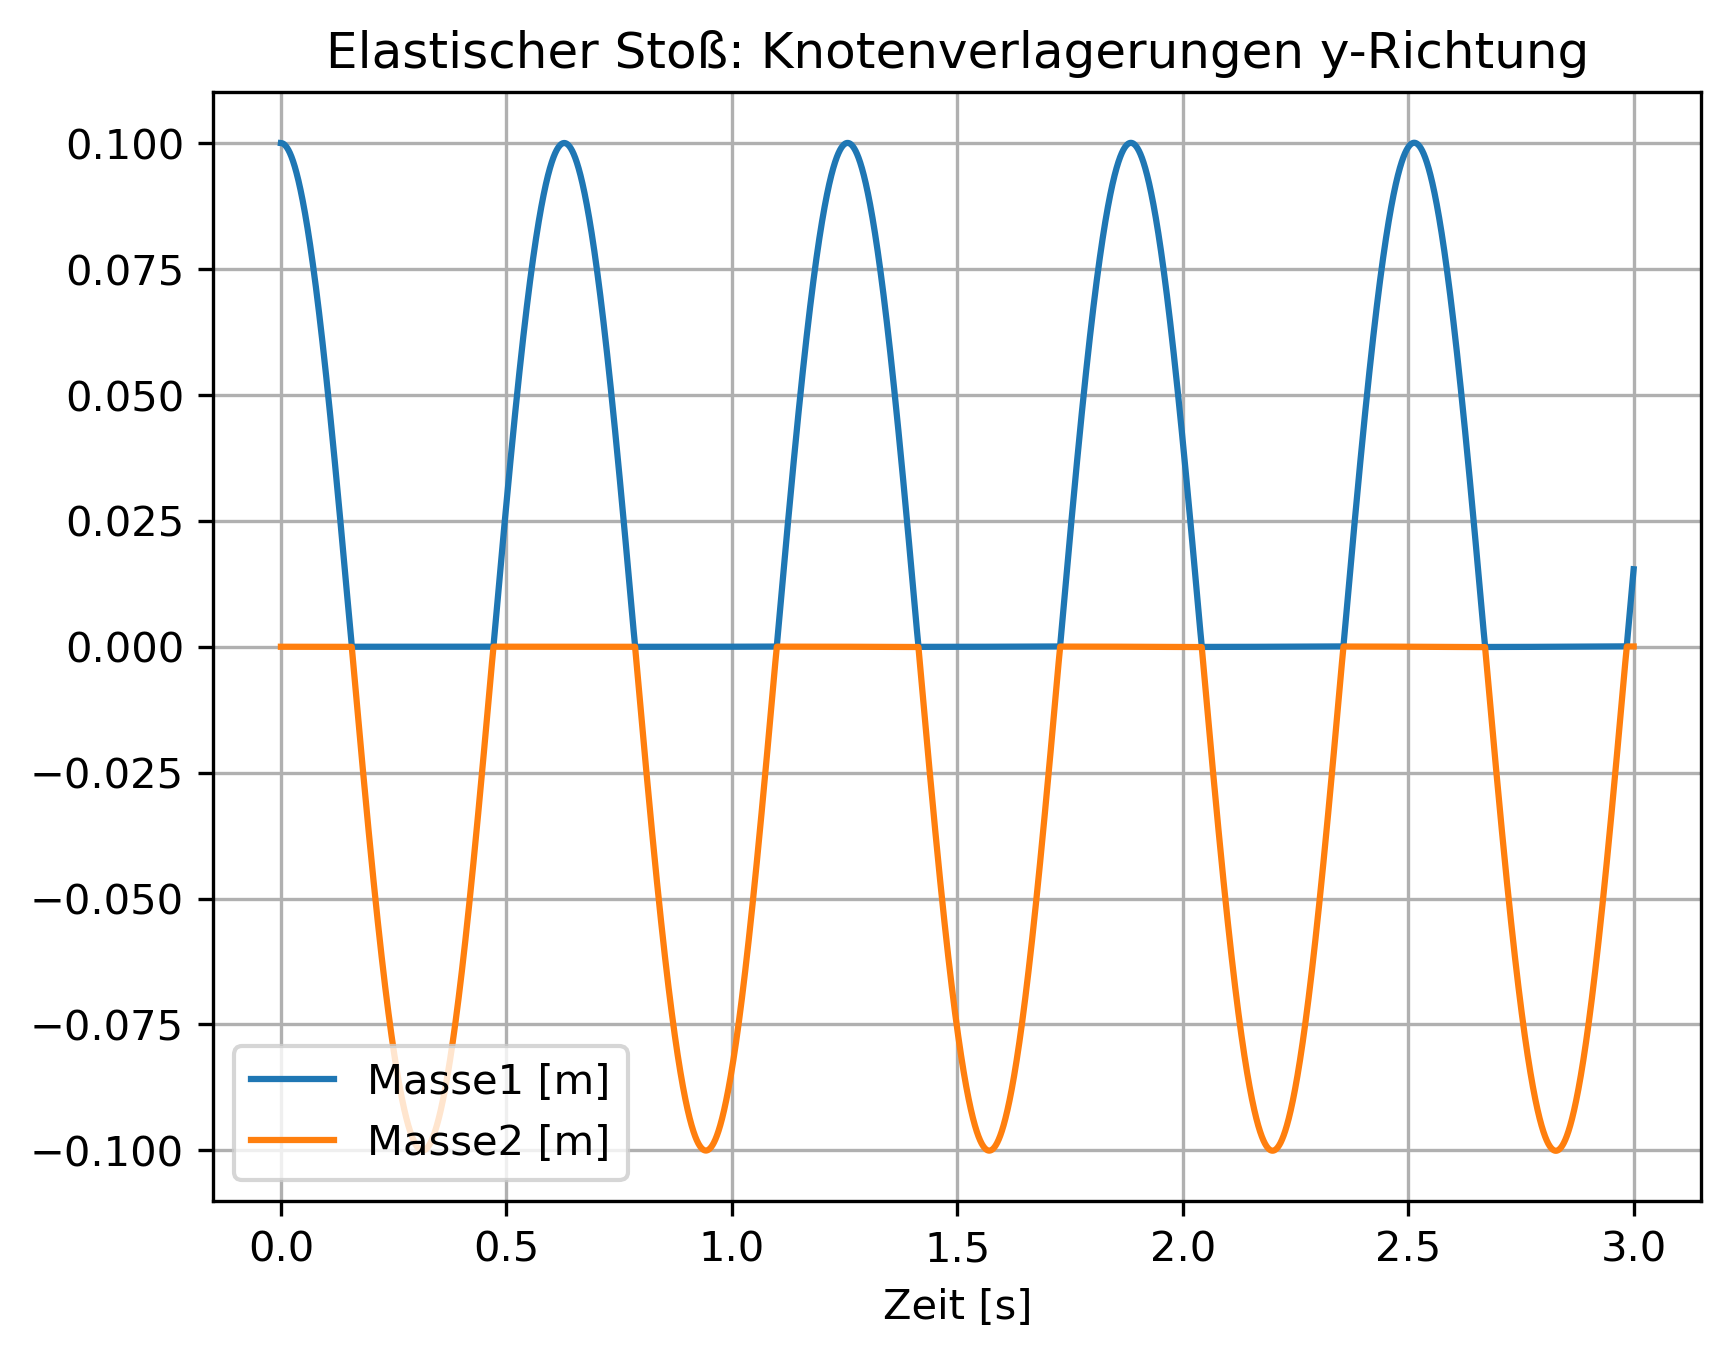

In [2]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Elastischer Stoß: Knotenverlagerungen y-Richtung')
plt.plot(datenlogger_t_Masse,datenlogger_K2_Masse.y,label='Masse1 [m]')
plt.plot(datenlogger_t_Masse,datenlogger_K3_Masse.y,label='Masse2 [m]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_elastischer_stoss1.png')

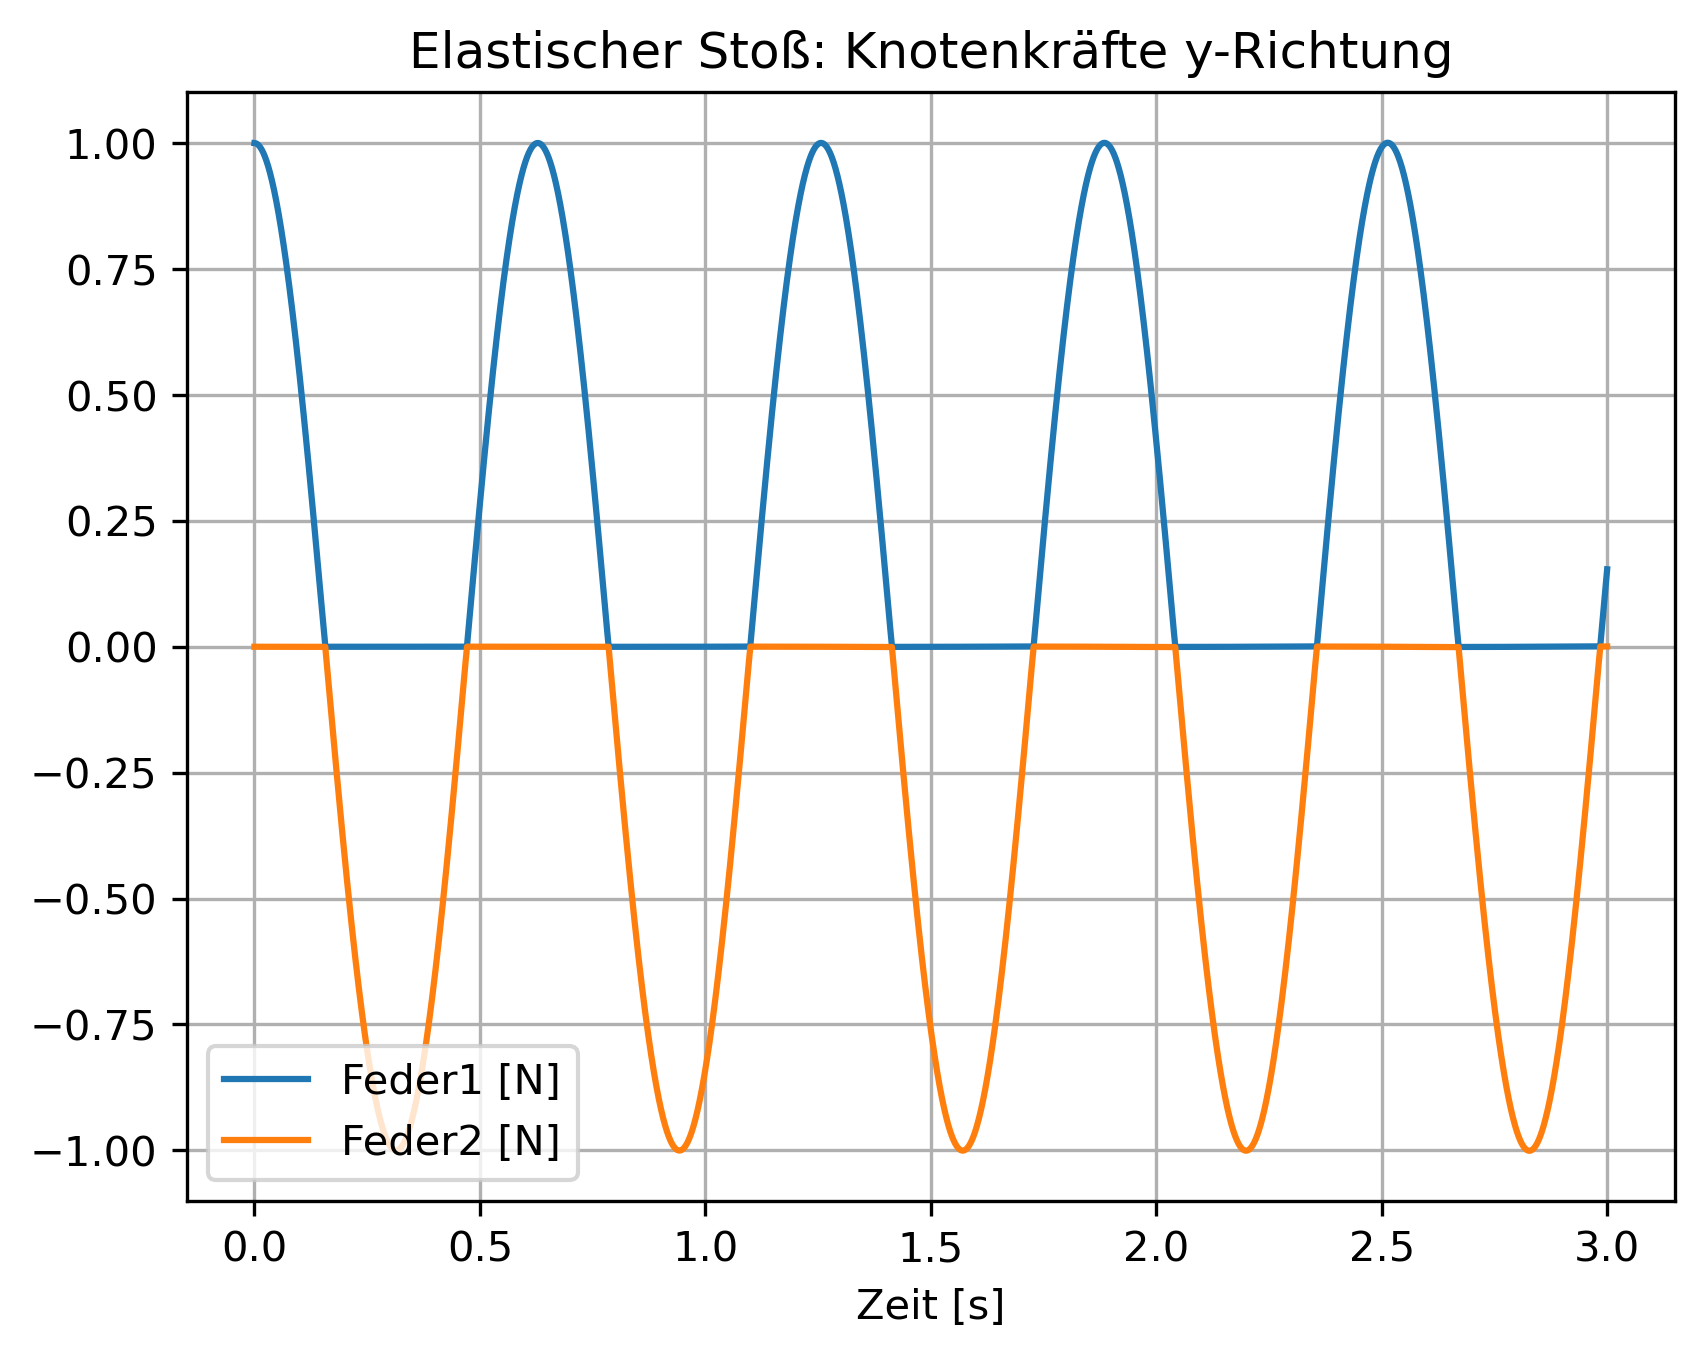

In [3]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Elastischer Stoß: Knotenkräfte y-Richtung')
plt.plot(datenlogger_t_Masse,datenlogger_K1_Masse.F_y,label='Feder1 [N]')
plt.plot(datenlogger_t_Masse,datenlogger_K4_Masse.F_y,label='Feder2 [N]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_elastischer_stoss2.png')

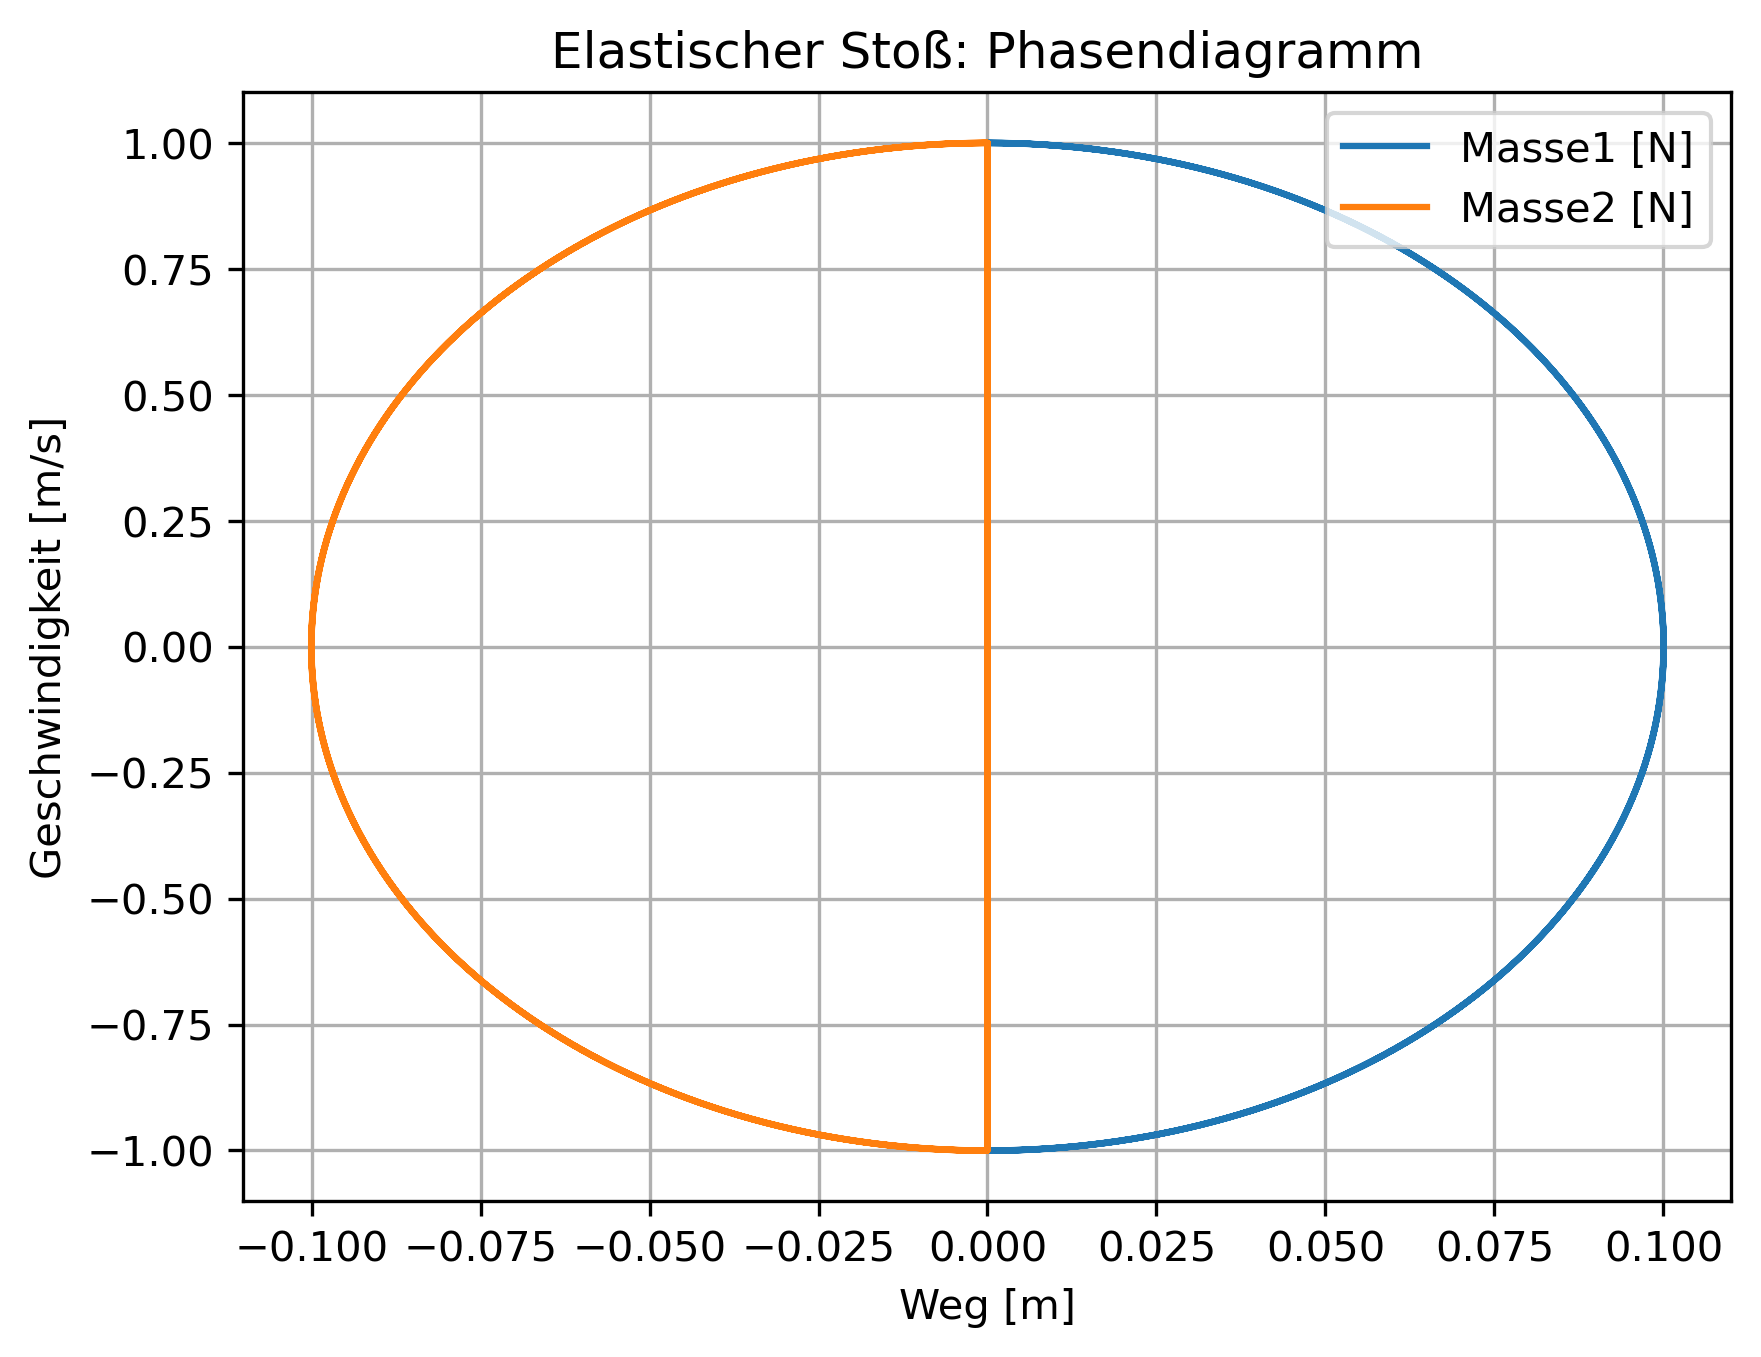

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Elastischer Stoß: Phasendiagramm')
plt.plot(datenlogger_K2_Masse.y,datenlogger_K2_Masse.y_p,label='Masse1 [N]')
plt.plot(datenlogger_K3_Masse.y,datenlogger_K3_Masse.y_p,label='Masse2 [N]')
#plt.xlim(0,20)
plt.xlabel('Weg [m]')
plt.ylabel('Geschwindigkeit [m/s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_elastischer_stoss3.png')

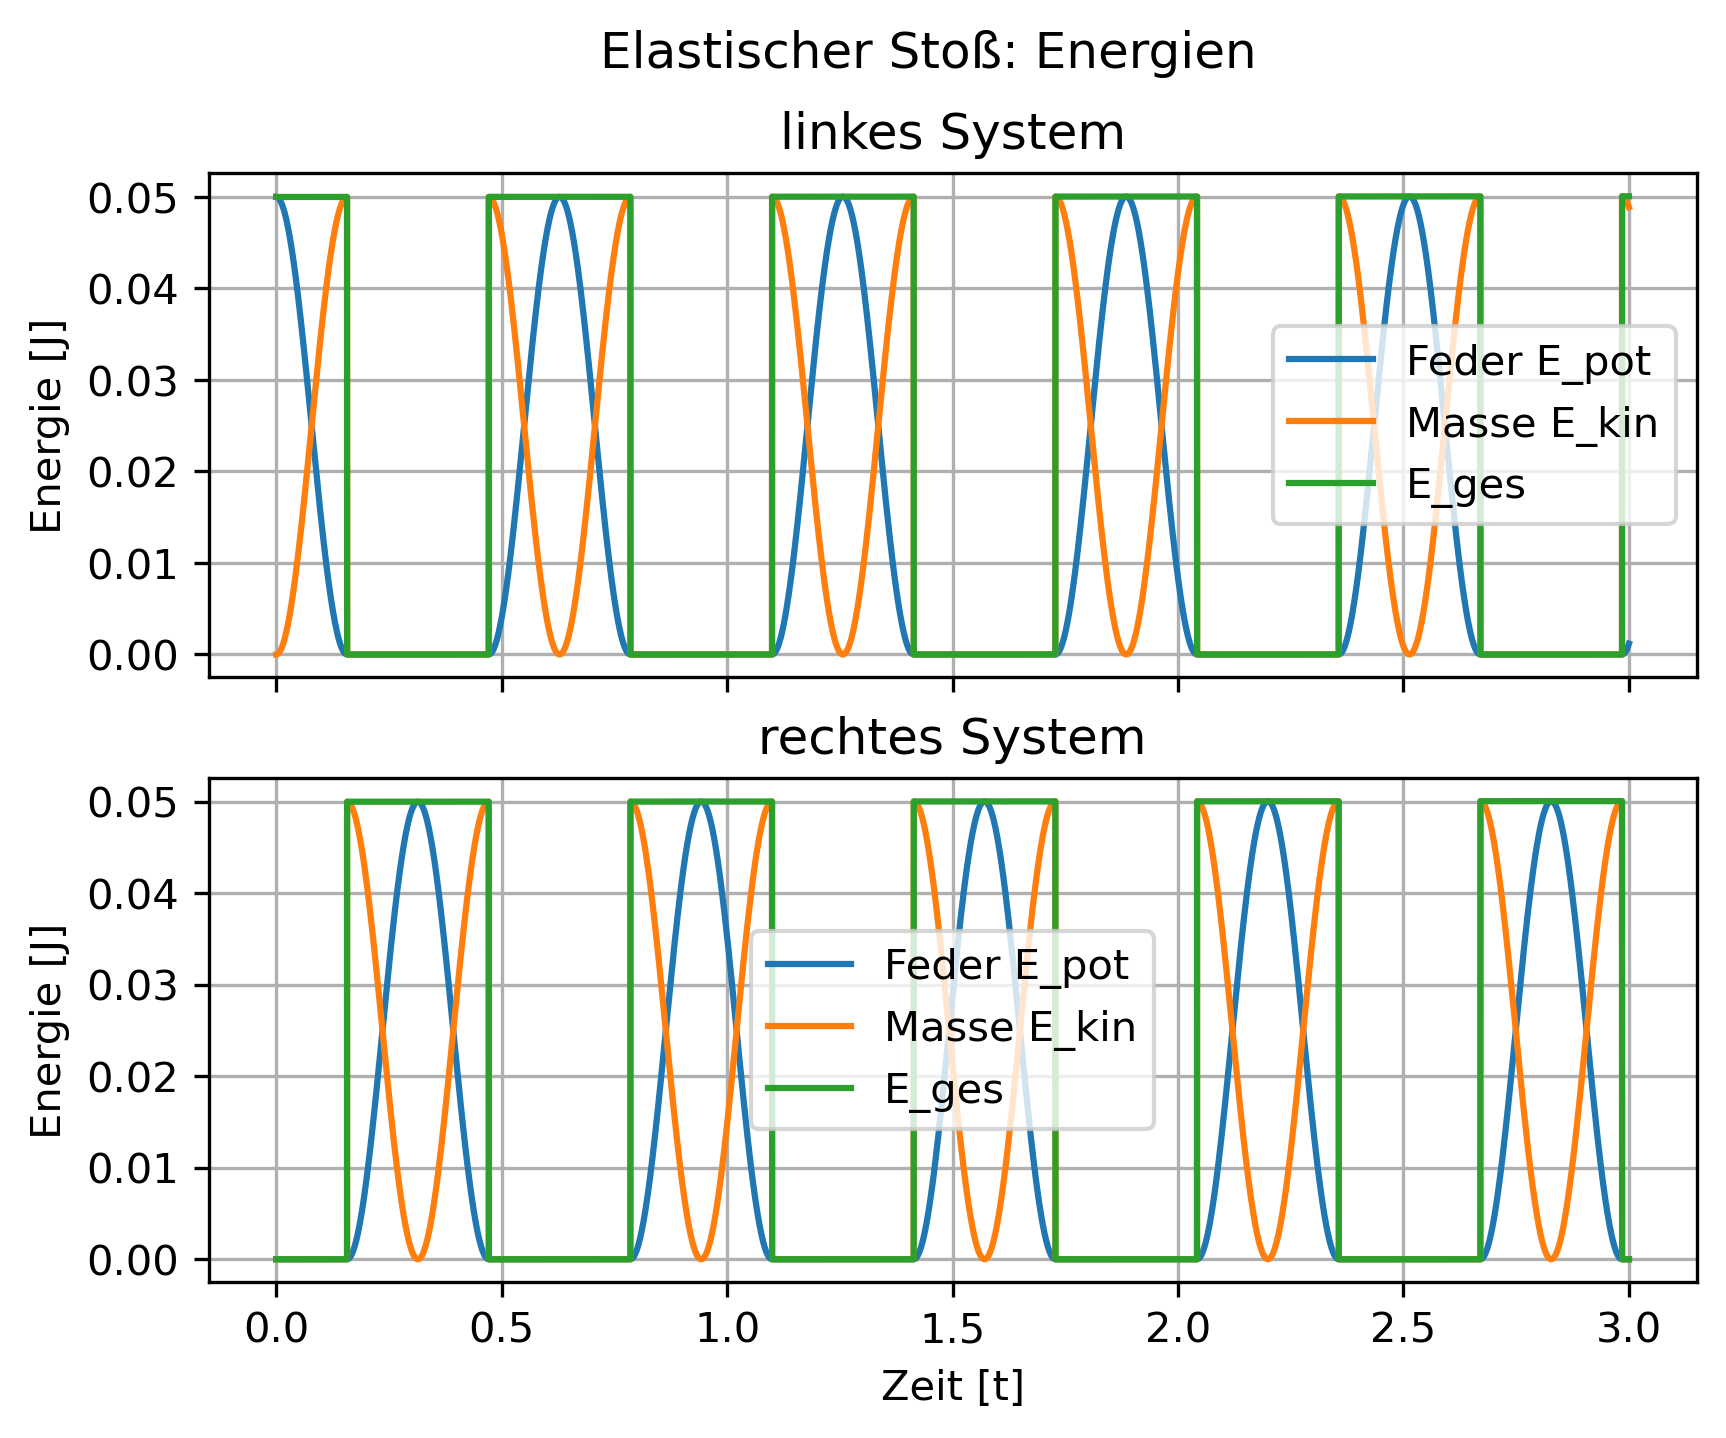

In [6]:
fig, axs = plt.subplots(2)
fig.patch.set_facecolor('white')
fig.suptitle('Elastischer Stoß: Energien')
E_ges1 = []
E_ges2 = []
E_ges = []
for point in range(len(datenlogger_E2_Masse.E_pot)):
    E_ges1.append(datenlogger_E1_Masse.E_pot[point] + datenlogger_E2_Masse.E_kin[point])     
    E_ges2.append(datenlogger_E4_Masse.E_kin[point] + datenlogger_E5_Masse.E_pot[point])     
    E_ges.append(datenlogger_E1_Masse.E_pot[point] + datenlogger_E2_Masse.E_kin[point] + datenlogger_E4_Masse.E_kin[point] + datenlogger_E5_Masse.E_pot[point]) 
axs[0].plot(datenlogger_t_Masse,datenlogger_E1_Masse.E_pot,label='Feder E_pot')
axs[0].plot(datenlogger_t_Masse,datenlogger_E2_Masse.E_kin,label='Masse E_kin')
axs[0].plot(datenlogger_t_Masse,E_ges1,label='E_ges')
axs[1].plot(datenlogger_t_Masse,datenlogger_E5_Masse.E_pot,label='Feder E_pot')
axs[1].plot(datenlogger_t_Masse,datenlogger_E4_Masse.E_kin,label='Masse E_kin')
axs[1].plot(datenlogger_t_Masse,E_ges2,label='E_ges')

for ax in axs.flat:
    ax.set(xlabel='Zeit [t]', ylabel='Energie [J]')
for ax in fig.get_axes():
    ax.label_outer()
axs[0].set_title('linkes System')
axs[1].set_title('rechtes System')
axs[0].grid()
axs[1].grid()
axs[0].legend()
axs[1].legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_elastischer_stoss4.png')